Email Spam Detection

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px 
import plotly.graph_objects as go 


from sklearn.utils import resample
import string 
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud
from collections import Counter

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Embedding,Dense,Flatten,Dropout
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gradio as gr
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("SPAM text message- Data.csv")

In [3]:
df.sample(10)

,Category,Message
3486,ham,No:-)i got rumour that you going to buy apartm...
5478,ham,No probably &lt;#&gt; %.
4825,ham,Not thought bout it... || Drink in tap & spile...
3915,ham,Today is ACCEPT DAY..U Accept me as? Brother S...
581,ham,Huh so early.. Then ü having dinner outside iz...
85,ham,"I call you later, don't have network. If urgnt..."
3375,ham,Also andros ice etc etc
5414,ham,East coast
4593,ham,Right it wasnt you who phoned it was someone w...
3267,ham,tap & spile at seven. * Is that pub on gas st ...


In [4]:
df['Message'][:3]

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
Name: Message, dtype: object

In [5]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

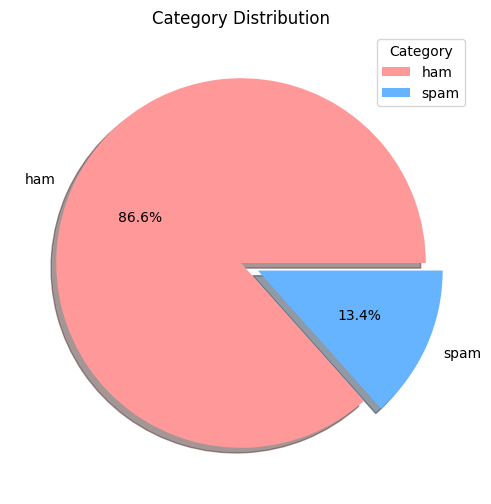

In [6]:
plt.figure(figsize=(6,6))
colors=['#ff9999','#66b3ff']
plt.pie(df['Category'].value_counts(),explode=(0,0.1),labels=['ham','spam'],autopct='%.1f%%',colors=colors,shadow=True)
plt.legend(title='Category')
plt.title('Category Distribution')
plt.show()

In [7]:
ham_msg=df[df['Category'] =='ham']
spam_msg=df[df['Category'] == 'spam']

In [8]:
ham_downsample=resample(
    ham_msg,
    replace=True,
    n_samples=len(spam_msg),
    random_state=42
)

In [9]:
print("The New Shape of Ham after downsampling is :",ham_downsample.shape)
print("The Shape of Spame is :",spam_msg.shape)

The New Shape of Ham after downsampling is : (747, 2)
The Shape of Spame is : (747, 2)


In [10]:
data=pd.concat([ham_downsample,spam_msg])

In [11]:
data

,Category,Message
1014,ham,Just buy a pizza. Meat lovers or supreme. U ge...
4364,ham,Evry Emotion dsn't hav Words.Evry Wish dsn't h...
3570,ham,She's fine. Sends her greetings
546,ham,Then any special there?
5121,ham,"Oops I did have it, &lt;#&gt; ?"
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [12]:
data['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

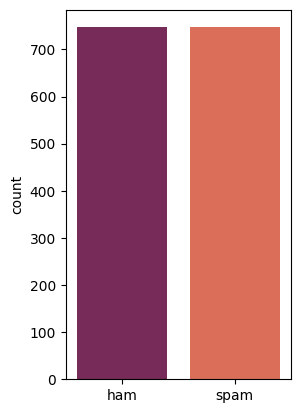

In [13]:
plt.subplot(1,2,2)
sns.barplot(x=data['Category'].unique(),palette='rocket',y=data['Category'].value_counts())
plt.show()

In [14]:
data['Message'].iloc[2]

"She's fine. Sends her greetings"

In [15]:
def convert_lowercase(text):
    text=text.lower()
    return text

In [16]:
data['Message']=data['Message'].apply(convert_lowercase)

In [17]:
data['Message'].iloc[2]

"she's fine. sends her greetings"

In [18]:
pd.set_option('display.max_colwidth', None)
print(data['Message'].iloc[:50].to_string())
pd.reset_option('display.max_colwidth')

1014                                                                                                                                just buy a pizza. meat lovers or supreme. u get to pick.
4364    evry emotion dsn't hav words.evry wish dsn't hav prayrs.. if u smile,d world is wit u.othrwise even d drop of tear dsn't lik 2 stay wit u.so b happy.. good morning, keep smiling:-)
3570                                                                                                                                                         she's fine. sends her greetings
546                                                                                                                                                                  then any special there?
5121                                                                                                                                                        oops i did have it,  &lt;#&gt; ?
3971                                               that

In [19]:
def remove_url(text):
    re_url=re.compile('https?://\S+|www.\S+')
    return re_url.sub('',text)

In [20]:
data['Message'] = data['Message'].apply(remove_url)

In [21]:
data['Message'].iloc[6]

'wait.i will come out.. &lt;#&gt;  min:)'

In [22]:
punctuation_list=string.punctuation
punctuation_list

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
def remove_punctuation(text):
    temp=str.maketrans('','',punctuation_list)
    return text.translate(temp)

In [24]:
data['Message']= data['Message'].apply(lambda x: remove_punctuation(x))

In [25]:
data['Message'].iloc[6]

'waiti will come out ltgt  min'

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
data['Message'].iloc[12]

'genius whats up how your brother pls send his number to my skype'

In [28]:
def remove_stopwords(text):
    stop_words=stopwords.words("english")
    
    imp_words=[]  
    
    for word in str(text).split():
        word = word.lower()
        
        if word not in stop_words:
            imp_words.append(word)
    output=" ".join(imp_words)
    return output

In [29]:
data['Message'] = data['Message'].apply(lambda text: remove_stopwords(text))

In [30]:
data['Message'].iloc[12]

'genius whats brother pls send number skype'

In [31]:
data['Message'].iloc[-5]

'want explicit sex 30 secs ring 02073162414 costs 20pmin gsex pobox 2667 wc1n 3xx'

In [32]:
def remove_digits(text):
    output=re.sub('[\d]','',text)
    return output

In [33]:
data['Message']=data['Message'].apply(remove_digits)

In [34]:
data['Message'].iloc[-5]

'want explicit sex  secs ring  costs pmin gsex pobox  wcn xx'

In [35]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
data['Message'].iloc[2]

'shes fine sends greetings'

In [37]:
def perform_stemming(text):
    stemmer=PorterStemmer()
    new_list=[]
    words=word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))
    return " ".join(new_list)

In [38]:
data['Message']=data['Message'].apply(perform_stemming)

In [39]:
data['Message'].iloc[2]

'she fine send greet'

EDA

In [40]:
all_spam_words=[]
for sentence in data[data['Category'] =='spam']['Message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
        
df=pd.DataFrame(Counter(all_spam_words).most_common(50),columns=['Word','Frequency'])
df.style.background_gradient(cmap='rocket')

,Word,Frequency
0,call,365
1,£,267
2,free,219
3,txt,163
4,u,154
5,ur,144
6,text,139
7,mobil,136
8,stop,118
9,claim,113


In [41]:
fig=px.treemap(df,path=['Word'],values='Frequency',title='Tree OF Most Common Words',color='Frequency')
fig.show()

In [42]:
fig=px.bar(
    df,x=df['Frequency'].sort_index(ascending=False),y='Word',color=df['Frequency'].sort_index(ascending=False),title='Common Words In Spam',
    width=700,height=700,
)
fig.update_layout(
    xaxis_title='Frequency',font_size=20,yaxis_title=None,title_font=dict(size=40)
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True)
fig.show()

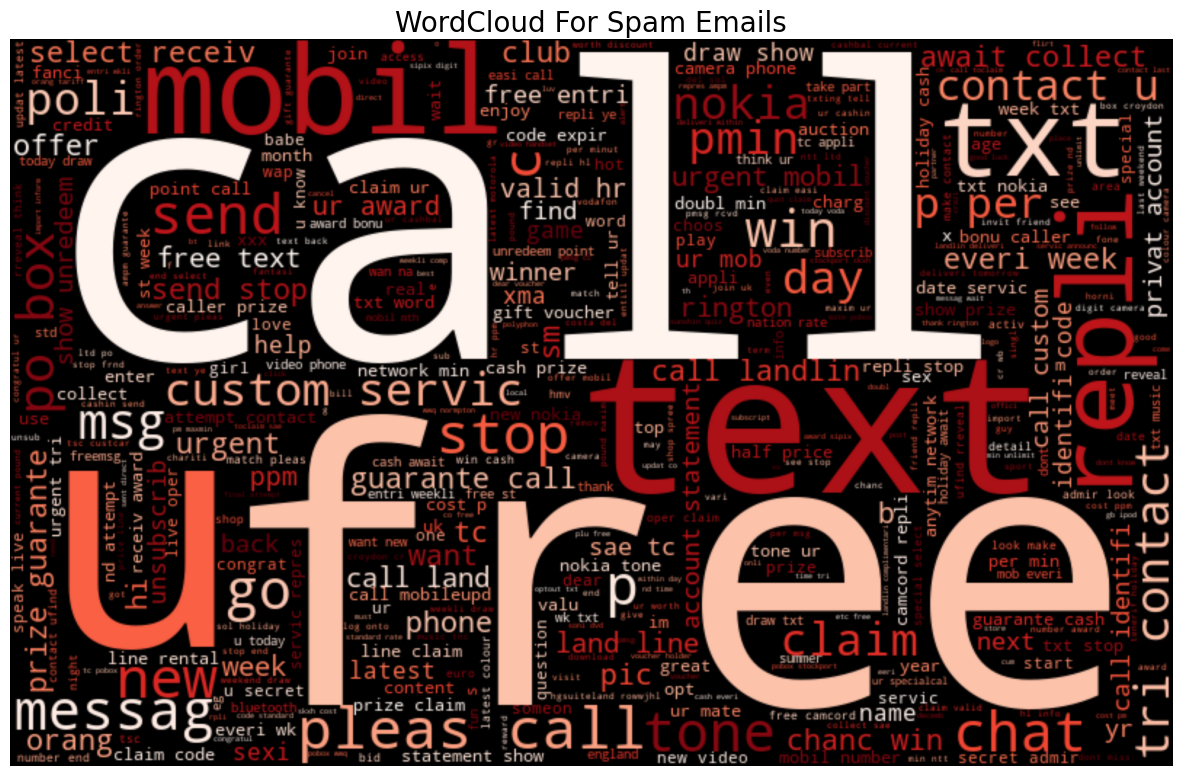

In [43]:
text=" ".join(data[data['Category'] =='spam']['Message'])
plt.figure(figsize=(15,10))
wordcloud=WordCloud(max_words=500,height=500,width=800,background_color='black',colormap='Reds').generate(text)
plt.imshow(wordcloud,interpolation='gaussian')
plt.axis('off')
plt.title("WordCloud For Spam Emails",fontsize=20)
plt.show()

In [44]:
all_ham_words=[]
for sentence in data[data['Category']=='ham']['Message'].to_list():
    for word in sentence.split():
        all_ham_words.append(word)

In [45]:
df_ham=pd.DataFrame(Counter(all_ham_words).most_common(50),columns=['Word','Frequency'])
df_ham.style.background_gradient(cmap='inferno')

,Word,Frequency
0,u,177
1,im,68
2,ur,67
3,go,66
4,get,60
5,dont,54
6,ok,49
7,come,48
8,like,44
9,know,43


In [46]:
fig=px.treemap(df_ham,path=['Word'],values='Frequency',title='TreeMap of Most Common Words',color='Frequency')
fig.update_layout(title_font=dict(size=30))
fig.show()

In [47]:
fig=px.bar(
    df_ham,x=df_ham['Frequency'],y='Word',color=df_ham['Frequency'],title='Common Words In Spam',
    width=700,height=700,
)
fig.update_layout(
    xaxis_title='Frequency',font_size=20,yaxis_title=None,title_font=dict(size=40)
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True)
fig.show()

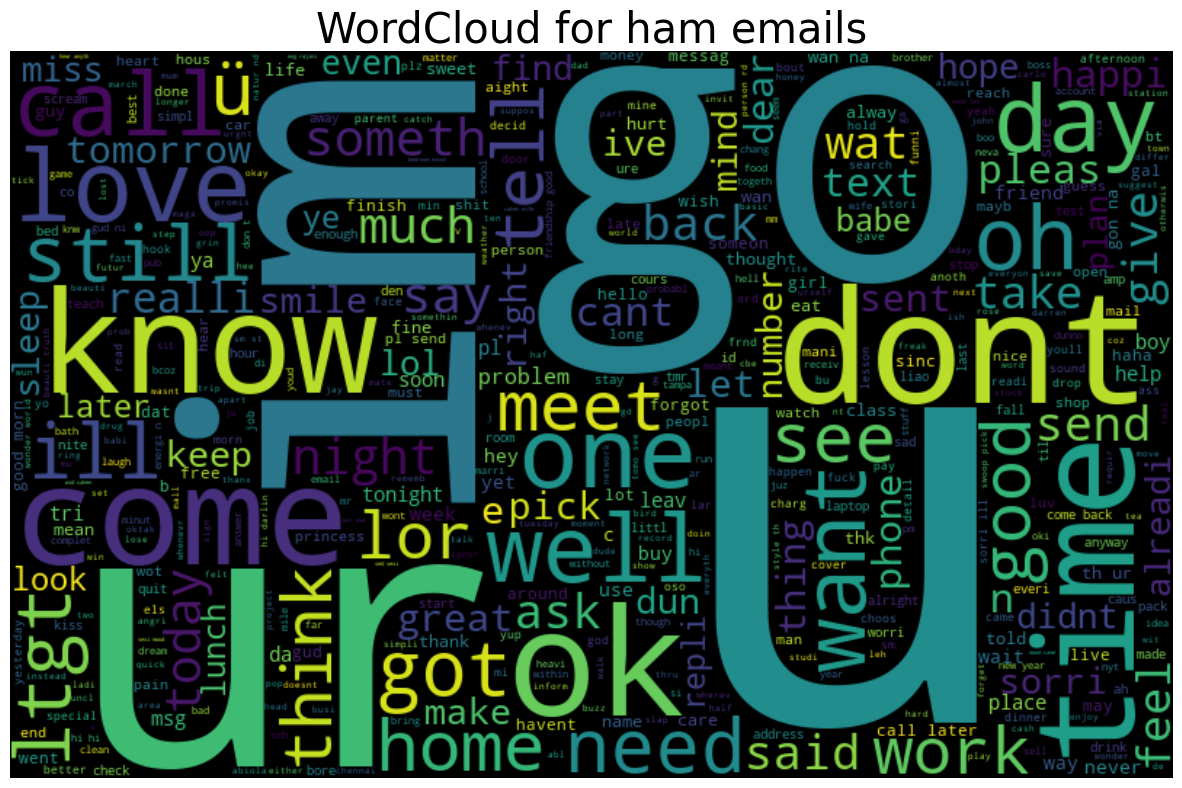

In [48]:
text = " ".join(data[data['Category'] == 'ham']['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 500, width = 800,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('WordCloud for ham emails', fontsize=30)
plt.axis('off')
plt.show()

In [49]:
def counter_word(text_col):
    count=Counter()
    for text in text_col.values:
        for word in text.split():
            count[word]+=1
    return count

counter=counter_word(data.Message)

In [50]:
counter

Counter({'call': 405,
         'u': 331,
         '£': 267,
         'free': 227,
         'ur': 211,
         'txt': 163,
         'text': 156,
         'get': 147,
         'mobil': 137,
         'stop': 124,
         'repli': 122,
         'claim': 113,
         'go': 103,
         'send': 96,
         'prize': 92,
         'im': 81,
         'dont': 76,
         'new': 75,
         'phone': 74,
         'pleas': 74,
         'servic': 73,
         'tone': 73,
         'p': 72,
         'nokia': 72,
         'week': 70,
         'day': 70,
         'know': 69,
         'award': 66,
         'win': 65,
         'cash': 65,
         'want': 63,
         'contact': 62,
         'urgent': 62,
         'time': 60,
         'min': 59,
         'like': 57,
         'today': 56,
         'ok': 54,
         'come': 53,
         'number': 53,
         'messag': 53,
         'custom': 53,
         'collect': 52,
         'love': 51,
         'guarante': 51,
         'one': 50,
         'tc': 5

In [51]:
MAX_NB_WORDS=len(counter)
MAX_NB_WORDS

3259

In [52]:
data['Message_Length']=data['Message'].apply(len)

In [53]:
data[['Message','Message_Length']]

,Message,Message_Length
1014,buy pizza meat lover suprem u get pick,38
4364,evri emot dsnt hav wordsevri wish dsnt hav pra...,141
3570,she fine send greet,19
546,special,7
5121,oop ltgt,8
...,...,...
5537,want explicit sex sec ring cost pmin gsex pobo...,54
5540,ask mobil chatlin inclu free min india cust se...,112
5547,contract mobil mnth latest motorola nokia etc ...,108
5566,remind o get pound free call credit detail gre...,92


In [54]:
data.iloc[0]


Category                                             ham
Message           buy pizza meat lover suprem u get pick
Message_Length                                        38
Name: 1014, dtype: object

In [55]:
MAX_LEN=data['Message_Length'].max()
MAX_LEN

398

In [56]:
tokeenizer=Tokenizer(num_words=MAX_NB_WORDS)
tokeenizer.fit_on_texts(data['Message'].values)

In [57]:
word_index=tokeenizer.word_index

In [58]:
word_index

{'call': 1,
 'u': 2,
 '£': 3,
 'free': 4,
 'ur': 5,
 'txt': 6,
 'text': 7,
 'get': 8,
 'mobil': 9,
 'stop': 10,
 'repli': 11,
 'claim': 12,
 'go': 13,
 'send': 14,
 'prize': 15,
 'im': 16,
 'dont': 17,
 'new': 18,
 'phone': 19,
 'pleas': 20,
 'servic': 21,
 'tone': 22,
 'p': 23,
 'nokia': 24,
 'week': 25,
 'day': 26,
 'know': 27,
 'award': 28,
 'win': 29,
 'cash': 30,
 'want': 31,
 'contact': 32,
 'urgent': 33,
 'time': 34,
 'min': 35,
 'like': 36,
 'today': 37,
 'ok': 38,
 'come': 39,
 'number': 40,
 'messag': 41,
 'custom': 42,
 'collect': 43,
 'love': 44,
 'guarante': 45,
 'one': 46,
 'tc': 47,
 'good': 48,
 'tri': 49,
 'box': 50,
 'back': 51,
 'see': 52,
 'msg': 53,
 'per': 54,
 'chat': 55,
 'tell': 56,
 'well': 57,
 'r': 58,
 'receiv': 59,
 'ppm': 60,
 'offer': 61,
 'everi': 62,
 'need': 63,
 'line': 64,
 'think': 65,
 'live': 66,
 'latest': 67,
 'show': 68,
 'take': 69,
 'still': 70,
 'draw': 71,
 'find': 72,
 'got': 73,
 'voucher': 74,
 'ill': 75,
 'landlin': 76,
 'help': 77,
 '

In [59]:
vocab_size = len(word_index)  
embedding_dim = int(math.sqrt(vocab_size) / 2)

In [60]:
vocab_size

3259

In [61]:
embedding_dim

28

Build the model

In [62]:
labelencoder=LabelEncoder()
data['Category']=labelencoder.fit_transform(data['Category'])
y=data['Category'].values

In [63]:
data['Category']

1014    0
4364    0
3570    0
546     0
5121    0
       ..
5537    1
5540    1
5547    1
5566    1
5567    1
Name: Category, Length: 1494, dtype: int32

In [64]:
print("Shape of label tensor",y.shape)

Shape of label tensor (1494,)


In [65]:
X=tokeenizer.texts_to_sequences(data['Message'].values)
X=pad_sequences(X,maxlen=MAX_LEN)
print('Shape of data tensor',X.shape)

Shape of data tensor (1494, 398)


In [66]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [67]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1120, 398) (1120,)
(374, 398) (374,)


In [68]:
model=tf.keras.Sequential([
    Embedding(input_dim=30000,output_dim=30,input_length=X_train.shape[1]),
    LSTM(128,return_sequences=True),
    Dropout(0.2),
    Dense(128,activation='relu'),
    Dropout(0.25),
    Flatten(),
    Dense(1,activation='sigmoid')
])

In [69]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 398, 30)           900000    
                                                                 
 lstm (LSTM)                 (None, 398, 128)          81408     
                                                                 
 dropout (Dropout)           (None, 398, 128)          0         
                                                                 
 dense (Dense)               (None, 398, 128)          16512     
                                                                 
 dropout_1 (Dropout)         (None, 398, 128)          0         
                                                                 
 flatten (Flatten)           (None, 50944)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [71]:
EPOCHS=10
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=EPOCHS)

Epoch 1/10
35/35 [==============================] - 5s 55ms/step - loss: 0.6709 - accuracy: 0.5946 - val_loss: 0.5022 - val_accuracy: 0.8342
Epoch 2/10
35/35 [==============================] - 2s 43ms/step - loss: 0.2480 - accuracy: 0.9098 - val_loss: 0.1952 - val_accuracy: 0.9358
Epoch 3/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0731 - accuracy: 0.9759 - val_loss: 0.1611 - val_accuracy: 0.9519
Epoch 4/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0933 - accuracy: 0.9786 - val_loss: 0.1565 - val_accuracy: 0.9465
Epoch 5/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0642 - accuracy: 0.9857 - val_loss: 0.1385 - val_accuracy: 0.9492
Epoch 6/10
35/35 [==============================] - 1s 43ms/step - loss: 0.0334 - accuracy: 0.9920 - val_loss: 0.1439 - val_accuracy: 0.9519
Epoch 7/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0237 - accuracy: 0.9946 - val_loss: 0.1444 - val_accuracy: 0.9439
Epoch 8/10
35

In [72]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 0s 18ms/step - loss: 0.1473 - accuracy: 0.9492


[0.14727821946144104, 0.9491978883743286]

In [73]:
acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
epoch=[i+1 for i in range(len(acc))]

In [74]:
acc_loss_df = pd.DataFrame({"Training Loss" : loss,
                            "Validation Loss": val_loss,
                            "Train Accuracy" : acc,
                            "Validation Accuracy" : val_acc,
                            "Epoch":epoch})


acc_loss_df.style.bar(cmap='Blues')

,Training Loss,Validation Loss,Train Accuracy,Validation Accuracy,Epoch
0,0.670886,0.502151,0.594643,0.834225,1
1,0.247989,0.195240,0.909821,0.935829,2
2,0.073067,0.161115,0.975893,0.951872,3
3,0.093319,0.156451,0.978571,0.946524,4
4,0.064159,0.138535,0.985714,0.949198,5
5,0.033393,0.143885,0.991964,0.951872,6
6,0.023714,0.144369,0.994643,0.943850,7
7,0.023994,0.142705,0.995536,0.949198,8
8,0.014534,0.147190,0.996429,0.949198,9
9,0.010122,0.147278,0.995536,0.949198,10


In [75]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=acc_loss_df['Epoch'],
                         y=acc_loss_df['Train Accuracy'],
                         mode='lines+markers',
                         name='Training Accuracy'
                         ))
fig.add_trace(go.Scatter(x=acc_loss_df['Epoch'],
                         y=acc_loss_df['Validation Accuracy'],
                         mode='lines+markers',
                         name='Training Accuracy'
                         ))
fig.update_layout(title = {'text': "<b>Training Accuracy Vs Validation Accuracy</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Accuracy",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'
fig.show()

In [76]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Training Loss'],
                         mode='lines+markers',
                         name='Training Loss'))

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Validation Loss'],
                         mode='lines+markers',
                         name = 'Validation Loss'))

fig.update_layout(title = {'text': "<b>Training Loss Vs Validation Loss</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Loss",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'

fig.show()

In [77]:
threshold=0.5
result=model.predict(X_test,verbose=2)
result=result>threshold
result=result.astype('int32')

12/12 - 1s - 504ms/epoch - 42ms/step


In [78]:
target_names = ['spam','ham']
print(classification_report(y_test, result, target_names=target_names))

              precision    recall  f1-score   support

        spam       0.93      0.97      0.95       180
         ham       0.97      0.93      0.95       194

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374



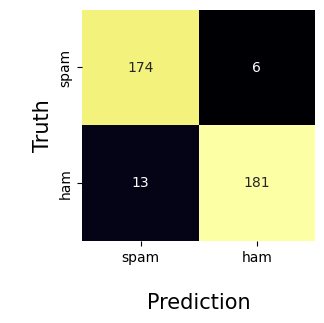

In [79]:
cm = confusion_matrix(y_test,result)
classes = ['spam','ham']

plt.figure(figsize = (3,3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar=False,cmap='inferno').set(xticklabels = classes, yticklabels = classes)
plt.xlabel("\nPrediction", size = 15)
plt.ylabel("\nTruth",  size = 15)
plt.show()

In [80]:
def predict_spam(predict_msg, threshold=0.5):
    new_seq = tokeenizer.texts_to_sequences([predict_msg])  
    padded = pad_sequences(new_seq, maxlen=MAX_LEN)        
    predictions = model.predict(padded)                    
    pred = predictions[0]                                  
    if pred > threshold:
        return "🔴 Spam"
    else:
        return "🟢 Ham"

In [81]:
interface = gr.Interface(
    fn=predict_spam,
    inputs=gr.Textbox(lines=2, placeholder="Type your message here..."),  
    outputs=gr.Textbox(label="Prediction"),                             
    title="🚫 Spam Detection System 🟢",                                 
    description="Enter a message to classify it as Spam or Ham. The system will analyze the content and determine whether it's spam or safe (ham).",
    examples=[                                                          
        ["Congratulations! You've won a $1000 gift card!"],
        ["Hey, are we still meeting tomorrow?"],
        ["You have been selected for a special offer! Click here to claim."],
        ["Don't forget to submit the report by 5 PM."]
    ],
    allow_flagging="never"                                                
)

interface.launch(share=True)  

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
